# 1. Load basic models and related functions.

In [1]:
# Import the necessary libraries, set the random seed, and configure some hyperparameters.
# “'AM', 'EM', 'QY', and 'LGAC' represent the absorption wavelength, emission wavelength, quantum yield, and molar absorptivity, respectively.”

import pandas as pd
import numpy as np
import os
import random
import copy
import dgl
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from dgllife.model import model_zoo
from dgllife.utils import smiles_to_bigraph
from dgllife.utils import EarlyStopping, Meter
from dgllife.utils import AttentiveFPAtomFeaturizer, AttentiveFPBondFeaturizer
from dgllife.data import MoleculeCSVDataset
from dgllife.model.gnn import AttentiveFPGNN
from dgllife.model.readout import AttentiveFPReadout
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

if torch.cuda.is_available():
    print('use GPU')
    device = 'cuda'
else:
    print('use CPU')
    device = 'cpu'

seed = 42
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

atom_featurizer = AttentiveFPAtomFeaturizer(atom_data_field='hv')
bond_featurizer = AttentiveFPBondFeaturizer(bond_data_field='he')
n_feats = atom_featurizer.feat_size('hv')
e_feats = bond_featurizer.feat_size('he')
print("n_feats", n_feats, "e_feats", e_feats)

graph_feat_size = 256
n_tasks = 4
dropout_g = 0.4
dropout_f = 0.5
dropout_l = 0.4

E:\Anaconda\envs\dye37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


use GPU
n_feats 39 e_feats 10


In [2]:
# Generate training and testing datasets.
def load_data_with_fp(data, fp_data, name, load):
    dataset = MoleculeCSVDataset(data,
                                 smiles_to_graph=smiles_to_bigraph,
                                 node_featurizer=atom_featurizer,
                                 edge_featurizer=bond_featurizer,
                                 smiles_column='SMILES',
                                 cache_file_path=str(name)+'_dataset_xanthene_fine-tuning.bin',
                                 task_names=['AM','EM','QY','LGAC'],
                                 load=load, init_mask=True, n_jobs=1
                                )

    combined_data = []
    for i, data_tuple in enumerate(dataset):
        if len(data_tuple) == 3:
            smiles, graph, label = data_tuple
            mask = None
        else:
            smiles, graph, label, mask = data_tuple
        fp = torch.tensor(fp_data[i], dtype=torch.float32)
        combined_data.append((graph, fp, label, mask))
    return combined_data

In [3]:
# Fingerprint data loading. Here, the main goal is to obtain the data scaling factor.
def load_fingerprints(fp_file):
    df = pd.read_csv(fp_file, header=None)
    return torch.tensor(df.values, dtype=torch.float32)
    
train_data = pd.read_csv('../1_MTATFP_all_types/dataset/random_split/random_train_15sol.csv')
valid_data = pd.read_csv('../1_MTATFP_all_types/dataset/random_split/random_valid_15sol.csv')

scaler = StandardScaler()
train_data[['AM', 'EM', 'QY', 'LGAC']] = scaler.fit_transform(train_data[['AM', 'EM', 'QY', 'LGAC']])
valid_data[['AM', 'EM', 'QY', 'LGAC']] = scaler.transform(valid_data[['AM', 'EM', 'QY', 'LGAC']])

train_fp = load_fingerprints('../1_MTATFP_all_types/dataset/random_split/random_train_15sol_morgan.csv')
valid_fp = load_fingerprints('../1_MTATFP_all_types/dataset/random_split/random_valid_15sol_morgan.csv')

In [4]:
# Define a multi-task model MTATFP
class GraphFingerprintsModel(nn.Module):
    def __init__(self, node_feat_size, edge_feat_size, fp_size, 
                 graph_feat_size=256, num_layers=2, num_timesteps=2, 
                 n_tasks=4, dropout_g=0, dropout_f=0, dropout_l=0):
        super(GraphFingerprintsModel, self).__init__()
        
        # Characterization of dye molecules.
        self.gnn = AttentiveFPGNN(node_feat_size=node_feat_size,
                                  edge_feat_size=edge_feat_size,
                                  num_layers=num_layers,
                                  graph_feat_size=graph_feat_size,
                                  dropout=dropout_g)
        self.readout = AttentiveFPReadout(feat_size=graph_feat_size,
                                          num_timesteps=num_timesteps,
                                          dropout=dropout_g)

        # Characterization of solvent molecules.
        self.fp_fc = nn.Sequential(
            nn.Linear(fp_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout_f),
            nn.Linear(256, graph_feat_size)
        )
        
        # Combine dye features and solvent features.
        self.predict = nn.Sequential(
            nn.Dropout(dropout_l),
            nn.Linear(graph_feat_size * 2, 128),
            nn.ReLU(),
            nn.Linear(128, n_tasks)
        )
        
    def forward(self, g, node_feats, edge_feats, fingerprints, get_node_weight=False):
        if edge_feats is None or 'he' not in g.edata.keys():
            num_edges = g.number_of_edges()
            edge_feats = torch.zeros((num_edges, edge_feats.size(1))).to(g.device)
        
        node_feats = self.gnn(g, node_feats, edge_feats)
        
        if get_node_weight:
            graph_feats, node_weights = self.readout(g, node_feats, get_node_weight)
            fp_feats = self.fp_fc(fingerprints)
            combined_feats = torch.cat([graph_feats, fp_feats], dim=1)
            return self.predict(combined_feats), node_weights
        else:
            graph_feats = self.readout(g, node_feats, get_node_weight)
            fp_feats = self.fp_fc(fingerprints)
            combined_feats = torch.cat([graph_feats, fp_feats], dim=1)
            return self.predict(combined_feats)

In [5]:
# Custom dataset class.
class MolecularDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Collate function for data loading.
def collate_fn(batch):
    graphs, fps, labels, masks = zip(*batch)
    graphs = dgl.batch(graphs)
    fps = torch.stack(fps)
    labels = torch.stack(labels)
    masks = torch.stack(masks) if masks[0] is not None else None
    return graphs, fps, labels, masks

# 2. Fine-tune model data loading.

In [6]:
node_feat_size = n_feats
edge_feat_size = e_feats
graph_feat_size = 256
num_layers = 2
num_timesteps = 2
fp_size = train_fp.shape[1]
n_tasks = 4
dropout_g = 0.4
dropout_f = 0.5
dropout_l = 0.4
batch_size = 32
learning_rate = 1e-3
epochs = 200
patience = 20

new_train_data = pd.read_csv('./dataset_xanthene/random_train_1.csv')
new_valid_data = pd.read_csv('./dataset_xanthene/random_test_1.csv')

new_train_data[['AM', 'EM', 'QY', 'LGAC']] = scaler.fit_transform(new_train_data[['AM', 'EM', 'QY', 'LGAC']])
new_valid_data[['AM', 'EM', 'QY', 'LGAC']] = scaler.transform(new_valid_data[['AM', 'EM', 'QY', 'LGAC']])

new_train_fp = load_fingerprints('./dataset_xanthene/random_train_1_morgan.csv')
new_valid_fp = load_fingerprints('./dataset_xanthene/random_test_1_morgan.csv')

new_train_datasets = load_data_with_fp(new_train_data, new_train_fp, 'new_train', True)
new_valid_datasets = load_data_with_fp(new_valid_data, new_valid_fp, 'new_valid', True)

Processing dgl graphs from scratch...


E:\Anaconda\envs\dye37\lib\site-packages\ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Processing dgl graphs from scratch...


In [7]:
new_train_dataset = MolecularDataset(new_train_datasets)
new_valid_dataset = MolecularDataset(new_valid_datasets)
new_train_loader = DataLoader(new_train_dataset, batch_size=32, collate_fn=collate_fn)
new_valid_loader = DataLoader(new_valid_dataset, batch_size=32, collate_fn=collate_fn)

In [8]:
# Fine-tune the model.
def fine_tune_model(model, train_loader, valid_loader, criterion, optimizer, epochs=200, patience=20):
    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_since_improvement = 0

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for graphs, fps, labels, masks in train_loader:
            graphs = graphs.to(device)
            fps = fps.to(device)
            labels = labels.to(device)

            node_feats = graphs.ndata['hv']
            edge_feats = graphs.edata['he']

            optimizer.zero_grad()
            predictions = model(graphs, node_feats, edge_feats, fps)

            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        train_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}')

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for graphs, fps, labels, masks in valid_loader:
                graphs = graphs.to(device)
                fps = fps.to(device)
                labels = labels.to(device)

                node_feats = graphs.ndata['hv']
                edge_feats = graphs.edata['he']

                predictions = model(graphs, node_feats, edge_feats, fps)
                loss = criterion(predictions, labels)
                val_loss += loss.item()

            val_loss /= len(valid_loader)
            print(f'Epoch {epoch}, Validation Loss: {val_loss:.4f}')

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                epochs_since_improvement = 0
            else:
                epochs_since_improvement += 1

            if epochs_since_improvement >= patience:
                print("Early stopping...")
                break

    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'model_xanthene_fine-tuning.pth')
    print('Fine-tuned model parameters saved to model_tiedun.pth')
    
def fine_tune_main():
    model = GraphFingerprintsModel(node_feat_size=n_feats,
                                   edge_feat_size=e_feats,
                                   fp_size=new_train_fp.shape[1],
                                   n_tasks=4).to(device)

    model.load_state_dict(torch.load('Model_all_types.pth'))

    new_train_dataset = MolecularDataset(new_train_datasets)
    new_valid_dataset = MolecularDataset(new_valid_datasets)
    new_train_loader = DataLoader(new_train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    new_valid_loader = DataLoader(new_valid_dataset, batch_size=32, collate_fn=collate_fn)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    fine_tune_model(model, new_train_loader, new_valid_loader, criterion, optimizer)

if __name__ == '__main__':
    fine_tune_main()

Epoch 1, Train Loss: 0.9925
Epoch 1, Validation Loss: 0.8675
Epoch 2, Train Loss: 0.6807
Epoch 2, Validation Loss: 0.6918
Epoch 3, Train Loss: 0.5724
Epoch 3, Validation Loss: 0.6172
Epoch 4, Train Loss: 0.5157
Epoch 4, Validation Loss: 0.5673
Epoch 5, Train Loss: 0.4763
Epoch 5, Validation Loss: 0.5297
Epoch 6, Train Loss: 0.4270
Epoch 6, Validation Loss: 0.4997
Epoch 7, Train Loss: 0.3913
Epoch 7, Validation Loss: 0.4728
Epoch 8, Train Loss: 0.3695
Epoch 8, Validation Loss: 0.4502
Epoch 9, Train Loss: 0.3450
Epoch 9, Validation Loss: 0.4301
Epoch 10, Train Loss: 0.3198
Epoch 10, Validation Loss: 0.4112
Epoch 11, Train Loss: 0.3124
Epoch 11, Validation Loss: 0.3947
Epoch 12, Train Loss: 0.2740
Epoch 12, Validation Loss: 0.3808
Epoch 13, Train Loss: 0.2582
Epoch 13, Validation Loss: 0.3679
Epoch 14, Train Loss: 0.2377
Epoch 14, Validation Loss: 0.3578
Epoch 15, Train Loss: 0.2217
Epoch 15, Validation Loss: 0.3477
Epoch 16, Train Loss: 0.2095
Epoch 16, Validation Loss: 0.3392
Epoch 17, 

# 3. Result Verification

In [9]:
device = 'cpu'
new_train_dataset = MolecularDataset(new_train_datasets)
new_valid_dataset = MolecularDataset(new_valid_datasets)
new_train_loader = DataLoader(new_train_dataset, batch_size=32, collate_fn=collate_fn)
new_valid_loader = DataLoader(new_valid_dataset, batch_size=32, collate_fn=collate_fn)

In [10]:
fp_size = train_fp.shape[1]
model = GraphFingerprintsModel(node_feat_size=n_feats,
                               edge_feat_size=e_feats,
                               graph_feat_size=graph_feat_size,
                               num_layers=2,
                               num_timesteps=2,
                               fp_size=fp_size,
                               n_tasks=4,
                               dropout_g=dropout_g,
                               dropout_f=dropout_f,
                               dropout_l=dropout_l).to(device)

model.load_state_dict(torch.load('model_xanthene_fine-tuning.pth', map_location=device))
model.eval()

GraphFingerprintsModel(
  (gnn): AttentiveFPGNN(
    (init_context): GetContext(
      (project_node): Sequential(
        (0): Linear(in_features=39, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (project_edge1): Sequential(
        (0): Linear(in_features=49, out_features=256, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
      )
      (project_edge2): Sequential(
        (0): Dropout(p=0.4, inplace=False)
        (1): Linear(in_features=512, out_features=1, bias=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (attentive_gru): AttentiveGRU1(
        (edge_transform): Sequential(
          (0): Dropout(p=0.4, inplace=False)
          (1): Linear(in_features=256, out_features=256, bias=True)
        )
        (gru): GRUCell(256, 256)
      )
    )
    (gnn_layers): ModuleList(
      (0): GNNLayer(
        (project_edge): Sequential(
          (0): Dropout(p=0.4, inplace=False)
          (1): Linear(in_features=512, out_f

In [11]:
def predict(model, dataloader):
    all_predictions = []
    with torch.no_grad():
        for graphs, fps, _, _ in dataloader:
            graphs = graphs.to(device)
            fps = fps.to(device)

            node_feats = graphs.ndata['hv']
            edge_feats = graphs.edata['he']

            predictions = model(graphs, node_feats, edge_feats, fps)
            all_predictions.append(predictions.cpu().numpy())

    return np.vstack(all_predictions)

train_predictions = predict(model, new_train_loader)
valid_predictions = predict(model, new_valid_loader)

def save_predictions(predictions, file_name):
    df = pd.DataFrame(predictions, columns=['AM','EM','QY','LGAC'])
    df.to_csv(file_name, index=False)

def reverse_standardization(predictions, scaler):
    return scaler.inverse_transform(predictions)

train_scale_predictions = reverse_standardization(train_predictions, scaler)
valid_scale_predictions = reverse_standardization(valid_predictions, scaler)

save_predictions(train_scale_predictions, 'train_predictions_xanthene_fine-tuning.csv')
save_predictions(valid_scale_predictions, 'test_predictions_xanthene_fine-tuning.csv')

In [12]:
def compute_metrics(pred_file, true_file, tasks=['AM', 'EM', 'QY', 'LGAC']):
    predictions = pd.read_csv(pred_file)
    true_labels = pd.read_csv(true_file)
    
    true_labels.replace([None, ''], np.nan, inplace=True)
    predictions.replace([None, ''], np.nan, inplace=True)
    metrics = {}
    for task in tasks:
        true_task = true_labels[task]
        pred_task = predictions[task]

        mask = ~true_task.isna()
        true_task = true_task[mask]
        pred_task = pred_task[mask]

        mae = mean_absolute_error(true_task, pred_task)
        rmse = np.sqrt(mean_squared_error(true_task, pred_task))
        r2 = r2_score(true_task, pred_task)

        metrics[task] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
        print(f"Task: {task} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

    all_true = true_labels[tasks].to_numpy().flatten()
    all_pred = predictions[tasks].to_numpy().flatten()

    mask = ~np.isnan(all_true)
    all_true = all_true[mask]
    all_pred = all_pred[mask]

    overall_mae = mean_absolute_error(all_true, all_pred)
    overall_rmse = np.sqrt(mean_squared_error(all_true, all_pred))
    overall_r2 = r2_score(all_true, all_pred)

    metrics['Overall'] = {'MAE': overall_mae, 'RMSE': overall_rmse, 'R2': overall_r2}

    print(f"Overall - MAE: {overall_mae:.4f}, RMSE: {overall_rmse:.4f}, R2: {overall_r2:.4f}")
    
    return metrics

train_metrics = compute_metrics('train_predictions_xanthene_fine-tuning.csv', './dataset_xanthene/random_train_1.csv')
valid_metrics = compute_metrics('test_predictions_xanthene_fine-tuning.csv', './dataset_xanthene/random_test_1.csv')

Task: AM - MAE: 7.0500, RMSE: 9.7006, R2: 0.9890
Task: EM - MAE: 6.1593, RMSE: 8.5111, R2: 0.9890
Task: QY - MAE: 0.0316, RMSE: 0.0469, R2: 0.9724
Task: LGAC - MAE: 0.0567, RMSE: 0.0936, R2: 0.9182
Overall - MAE: 3.9942, RMSE: 7.0864, R2: 0.9994
Task: AM - MAE: 15.0552, RMSE: 22.8094, R2: 0.9409
Task: EM - MAE: 13.9577, RMSE: 22.9816, R2: 0.9043
Task: QY - MAE: 0.1137, RMSE: 0.1620, R2: 0.7172
Task: LGAC - MAE: 0.1559, RMSE: 0.2513, R2: 0.5054
Overall - MAE: 8.9858, RMSE: 17.9540, R2: 0.9963


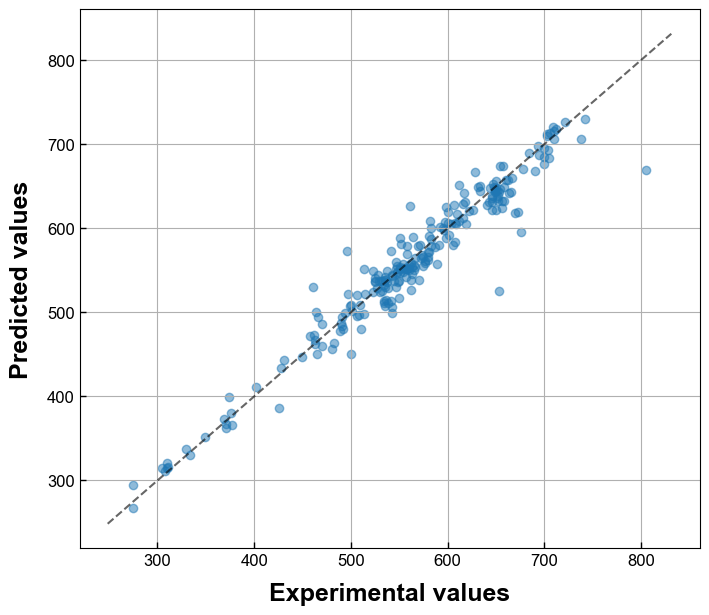

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

experiment_data = pd.read_csv('./dataset_xanthene/random_test_1.csv')
prediction_data = pd.read_csv('test_predictions_xanthene_fine-tuning.csv')

plt.figure(figsize=(8, 7))
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.scatter(experiment_data['AM'], prediction_data['AM'], alpha=0.5)
plt.xlabel('Experimental values', labelpad=10, fontweight='bold')
plt.ylabel('Predicted values', labelpad=10, fontweight='bold')
plt.tick_params(axis='x', direction='in', length=4, width=1)
plt.tick_params(axis='y', direction='in', length=4, width=1)

# 获取坐标轴范围
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.plot([xmin, xmax], [xmin, xmax], color='black', linestyle='--',alpha=0.6)

plt.grid(True)
plt.show()

# 4. Visualization of atomic weights.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from dgllife.model import model_zoo
from dgllife.utils import smiles_to_bigraph
from dgllife.utils import AttentiveFPAtomFeaturizer
from dgllife.utils import AttentiveFPBondFeaturizer
from dgllife.data import MoleculeCSVDataset
import dgl
import matplotlib
import matplotlib.cm as cm
from IPython.display import SVG, display
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

def draw(mol_id, dataset, timestep):
    g, fps, label, _ = dataset[mol_id]
    g = dgl.batch([g])
    fps = fps.unsqueeze(0)
    atom_feats, bond_feats = g.ndata.pop('hv'), g.edata.pop('he')
    preds, atom_weights1 = model(g, atom_feats, bond_feats, fps, get_node_weight=True)
    assert timestep < len(atom_weights1)
    atom_weights1 = atom_weights1[timestep]
    min_value = torch.min(atom_weights1)
    max_value = torch.max(atom_weights1)
    atom_weights = (atom_weights1 - min_value) / (max_value - min_value)
    c=atom_weights.detach().cpu().numpy().flatten().tolist()
    norm = matplotlib.colors.Normalize(vmin=0,vmax=(sum(c)/len(c)))
    cmap = cm.get_cmap('summer_r') # viridis,magma,inferno,cividis,coolwarm,plasma,summer_r
    plt_colors = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    atom_colors = {i: plt_colors.to_rgba(atom_weights[i].data.item()) for i in range(g.number_of_nodes())}
    plt_colors._A = [] 
    cb = plt.colorbar(plt_colors) 
    cb.set_ticks([]) 
    
    smiless = train_data['SMILES']
    smiles=smiless[mol_id]
    mol = Chem.MolFromSmiles(smiles)
    rdDepictor.Compute2DCoords(mol)
    drawer = rdMolDraw2D.MolDraw2DSVG(300,300)
    
    drawer.SetFontSize(1)
    op = drawer.drawOptions().addAtomIndices=True
    
    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
    drawer.DrawMolecule(mol,highlightAtoms=range(g.number_of_nodes()),highlightBonds=[],
    highlightAtomColors=atom_colors)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:','')
    # 保存SVG图像
    svg_file_path = f"molecule_{mol_id}.svg"  # 设置文件名
    with open(svg_file_path, 'w') as f:
        f.write(svg)
    display(SVG(svg))
    avg_all_weight = sum(atom_weights)/len(atom_weights)
    list_a=[]
    num=0
    for i in atom_weights:
        list_a.append([i,num])
        num+=1
    return smiles,label,preds,list_a,avg_all_weight

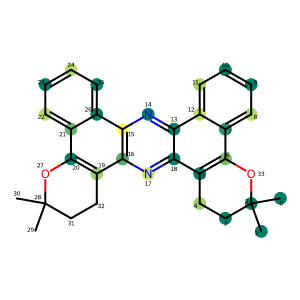

('CC1(C)CCc2c(c3ccccc3c3nc4c(nc23)c2c(c3ccccc34)OC(C)(C)CC2)O1',
 tensor([-3.2638,  0.0000,  0.0000,  0.0000]),
 tensor([[-1.2198, -0.7518, -0.1752,  0.1440]], grad_fn=<AddmmBackward0>),
 [[tensor([0.6150], grad_fn=<UnbindBackward0>), 0],
  [tensor([0.9292], grad_fn=<UnbindBackward0>), 1],
  [tensor([0.7483], grad_fn=<UnbindBackward0>), 2],
  [tensor([0.6531], grad_fn=<UnbindBackward0>), 3],
  [tensor([0.1875], grad_fn=<UnbindBackward0>), 4],
  [tensor([0.6150], grad_fn=<UnbindBackward0>), 5],
  [tensor([0.2659], grad_fn=<UnbindBackward0>), 6],
  [tensor([0.4300], grad_fn=<UnbindBackward0>), 7],
  [tensor([0.1549], grad_fn=<UnbindBackward0>), 8],
  [tensor([0.8820], grad_fn=<UnbindBackward0>), 9],
  [tensor([0.6123], grad_fn=<UnbindBackward0>), 10],
  [tensor([0.1609], grad_fn=<UnbindBackward0>), 11],
  [tensor([0.1269], grad_fn=<UnbindBackward0>), 12],
  [tensor([0.8820], grad_fn=<UnbindBackward0>), 13],
  [tensor([0.8894], grad_fn=<UnbindBackward0>), 14],
  [tensor([0.], grad_fn=<Unb

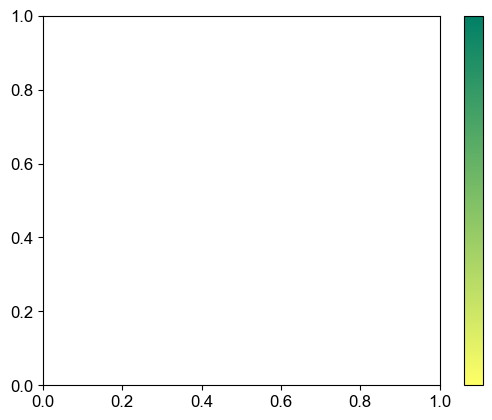

In [15]:
draw(900,new_train_datasets, 0)